# result matches with batista paper 

but this is for wangBuzsaki HH model 
# there is still parameter search issue with bati

In [59]:
import brainpy as bp
import brainpy.math as bm
import matplotlib.pyplot as plt
from brainpy._src.integrators import JointEq
from brainpy._src.context import share

bp.math.set_dt(0.05)

class A2(bp.neurons.HH):
  def __init__(self, size, ENa=55., EK=-90., EL=-65, C=1.0, gNa=35.,
               gK=9., gL=0.1, V_th=20., method='exp_auto'):
    super().__init__(size=size, method=method)
    self.size = size

    # parameters
    self.ENa = ENa
    self.EK = EK
    self.EL = EL
    self.C = C
    self.gNa = gNa
    self.gK = gK
    self.gL = gL
    self.V_th = V_th

    self.input = bm.Variable(bm.ones(size) * 1.2)
    # self.t_last_spike = bm.Variable(bm.ones(size) * -1e7)

  def m_inf(self, V):
    alpha = -0.1 * (V + 35) / (bm.exp(-0.1 * (V + 35)) - 1)
    # print('m_inf*****')
    beta = 4 * bm.exp(-(V + 60) / 18)
    return alpha / (alpha + beta)

  def dn(self, n, t, V):
    alpha = -0.01 * (V + 34) / (bm.exp(-0.1 * (V + 34)) - 1)
    # print('dn_alpha*****')
    beta = 0.125 * bm.exp(-(V + 44) / 80)
    dndt = alpha * (1 - n) - beta * n
    return 5 * dndt

  def dh(self, h, t, V):
    alpha = 0.07 * bm.exp(-(V + 58) / 20)
    beta = 1 / (bm.exp(-0.1 * (V + 28)) + 1)
    dhdt = alpha * (1 - h) - beta * h
    return 5 * dhdt

  def dV(self, V, t, h, n, I):
    # print('n,m_inf,h=', self.m_inf(V),n,h)
    INa = self.gNa * self.m_inf(V) ** 3 * h * (V - self.ENa)
    # print('I ki value =', INa)
    IK = self.gK * n ** 4 * (V - self.EK)
    IL = self.gL * (V - self.EL)
    dVdt = (- INa - IK - IL + I) / self.C
    return dVdt

  @property
  def derivative(self):
    return JointEq(self.dV, self.dh, self.dn)  # , self.dh, self.dn, self.ds, self.dc, self.dq)

  def update(self, tdi):
    # t = share.load('t')
    # dt = share.load('dt')
    # x = 1.2 if x is None else x
    # print('x=', x )

    V, h, n = self.integral(self.V.value, self.h.value, self.n.value, tdi.t, self.input, tdi.dt)
    # V += self.sum_delta_inputs()
    self.spike.value = bm.logical_and(self.V < self.V_th, V >= self.V_th)
    # self.t_last_spike.value = bm.where(self.spike, tdi.t, self.t_last_spike)
    self.V.value = V
    self.h.value = h
    self.n.value = n
    self.input[:] = 0 #1.2
    return self.spike.value


num = 100
# dyn neurons
neu =  A2(num) #A1(num) #bp.neurons.HH(num)#bp.dyn.HH(10) #HH(num) #bp.neurons.WangBuzsakiModel(num) #HH(num) #bp.dyn.WangBuzsakiHH(num) #bp.neurons.WangBuzsakiModel(num) #HH(num)
neu.V[:] = -70. + bm.random.normal(size=num) * 20

In [60]:
class BaseAMPASyn(bp.SynConn):
  def __init__(self, pre, post, conn, delay=0, g_max=0.1/100, E=-80, alpha=0.53,
               beta=0.18, T=1, T_duration=1, method='exp_auto'):
    super(BaseAMPASyn, self).__init__(pre=pre, post=post, conn=conn)

    # check whether the pre group has the needed attribute: "spike"
    self.check_pre_attrs('spike')

    # check whether the post group has the needed attribute: "input" and "V"
    self.check_post_attrs('input', 'V')

    # parameters
    self.delay = delay
    self.g_max = g_max
    self.E = E
    self.alpha = alpha
    self.beta = beta
    self.T = T
    self.T_duration = T_duration

    # use "LengthDelay" to store the spikes of the pre-synaptic neuron group
    self.delay_step = int(delay/bm.get_dt())
    self.pre_spike = bm.LengthDelay(pre.spike, self.delay_step)

    # store the arrival time of the pre-synaptic spikes
    self.spike_arrival_time = bm.Variable(bm.ones(self.pre.num) * -1e7)

    # integral function
    self.integral = bp.odeint(self.derivative, method=method)

  def derivative(self, g, t, TT):
    dg = self.alpha * TT * (1 - g) - self.beta * g
    return dg

/Users/shubhangi_goyal/opt/miniconda3/lib/python3.9/site-packages/brainpy/_src/deprecations.py:89: DeprecationWarning: brainpy.SynConn is deprecated. Use brainpy.dyn.SynConn instead.
  _deprecate(message)


In [61]:
class AMPAAll2All(BaseAMPASyn):
  def __init__(self, *args, **kwargs):
    super(AMPAAll2All, self).__init__(*args, **kwargs)
    
     # connection matrix
    self.conn_mat = self.conn.require('conn_mat').astype(float)

    # synapse gating variable
    # -------
    # The synapse variable has the shape of the post-synaptic group
    self.g = bm.Variable(bm.zeros((self.pre.num, self.post.num)))
    

  def update(self, tdi, x=None):
    _t, _dt = tdi.t, tdi.dt
    delayed_spike = self.pre_spike(self.delay_step)
    self.pre_spike.update(self.pre.spike)
    self.spike_arrival_time.value = bm.where(delayed_spike, _t, self.spike_arrival_time)
    TT = ((_t - self.spike_arrival_time) < self.T_duration) * self.T
          #*1/(1+bm.exp(-(self.pre.V-20)/2)))
    # TT = 1/(1+bm.exp(-(self.pre.V-20)/2))
    #TT = TT.reshape((-1, 1))  # NOTE: here is the difference
    TT = TT.reshape((-1, 1))* self.conn_mat
    self.g.value = self.integral(self.g, _t, TT, dt=_dt)
    g_post = self.g.sum(axis=0) # NOTE: here is also different

    self.post.input += self.g_max * g_post * (self.E - self.post.V)
    print('output =', self.post.input)
    

# probability 1 

  0%|          | 0/10000 [00:00<?, ?it/s]

output = Variable(value=Traced<ShapedArray(float32[100])>with<DynamicJaxprTrace(level=2/0)>, dtype=float32)
output = Variable(value=Traced<ShapedArray(float32[100])>with<DynamicJaxprTrace(level=1/0)>, dtype=float32)


/Users/shubhangi_goyal/opt/miniconda3/lib/python3.9/site-packages/brainpy/_src/dynsys.py:294: UserWarning: 
From brainpy>=2.4.3, update() function no longer needs to receive a global shared argument.

Instead of using:

  def update(self, tdi, *args, **kwagrs):
     t = tdi['t']
     ...

Please use:

  def update(self, *args, **kwagrs):
     t = bp.share['t']
     ...

  warnings.warn(_update_deprecate_msg, UserWarning)


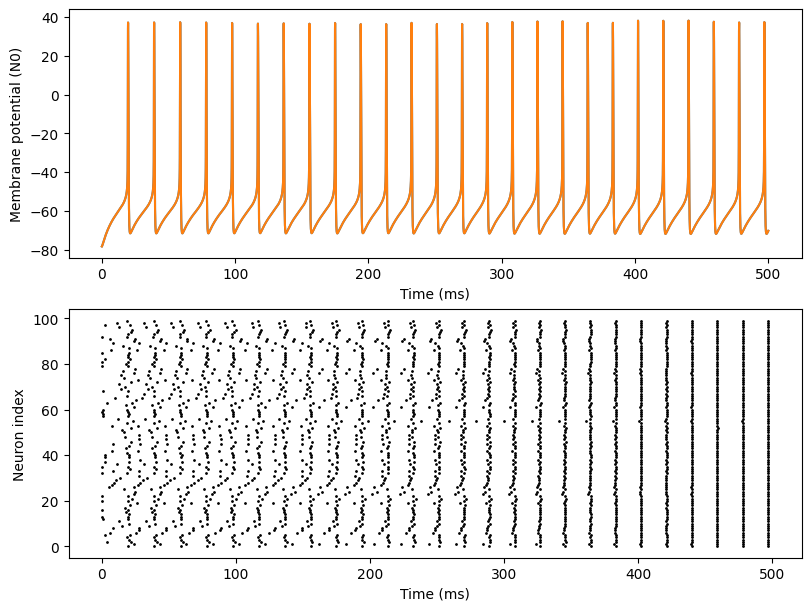

In [4]:
syn = AMPAAll2All(pre=neu, post=neu, conn=bp.connect.All2All(include_self=False)) #include_self=False)) #
net = bp.Network(neu=neu, syn=syn)
runner = bp.DSRunner(net, monitors=['neu.spike', 'neu.V'], inputs=['neu.input',1.2]) #bm.random.uniform(1.2,1.32,100)]) #
runner.run(duration=500.) #,inputs=inputs )

fig, gs = bp.visualize.get_figure(2, 1, 3, 8)

fig.add_subplot(gs[0, 0])
bp.visualize.line_plot(runner.mon.ts, runner.mon['neu.V'], ylabel='Membrane potential (N0)')
bp.visualize.line_plot(runner.mon.ts, runner.mon['neu.V'])

fig.add_subplot(gs[1, 0])
bp.visualize.raster_plot(runner.mon.ts, runner.mon['neu.spike'], show=True)
plt.show()


# probability 0.8

  0%|          | 0/14000 [00:00<?, ?it/s]

output = Variable(value=Traced<ShapedArray(float32[100])>with<DynamicJaxprTrace(level=2/0)>, dtype=float32)
output = Variable(value=Traced<ShapedArray(float32[100])>with<DynamicJaxprTrace(level=1/0)>, dtype=float32)


/Users/shubhangi_goyal/opt/miniconda3/lib/python3.9/site-packages/brainpy/_src/dynsys.py:294: UserWarning: 
From brainpy>=2.4.3, update() function no longer needs to receive a global shared argument.

Instead of using:

  def update(self, tdi, *args, **kwagrs):
     t = tdi['t']
     ...

Please use:

  def update(self, *args, **kwagrs):
     t = bp.share['t']
     ...

  warnings.warn(_update_deprecate_msg, UserWarning)


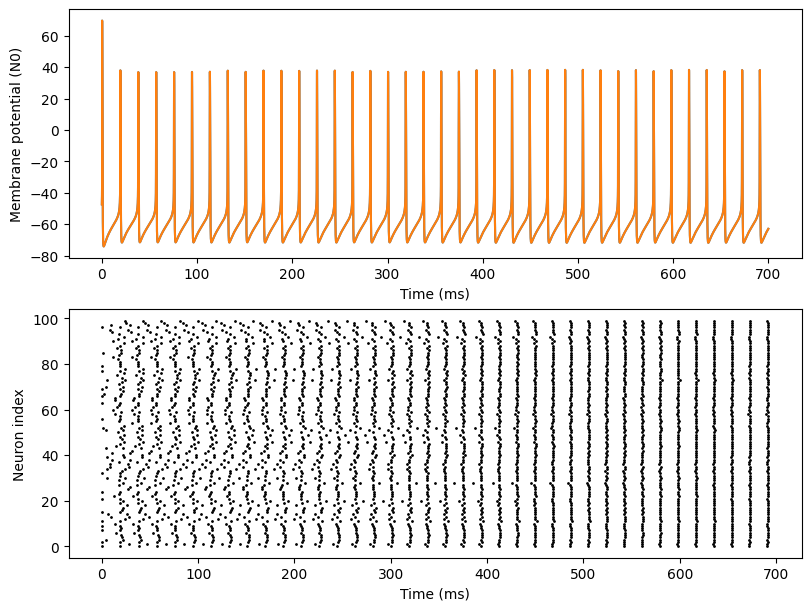

In [22]:
syn = AMPAAll2All(pre=neu, post=neu, conn= bp.connect.FixedProb(prob=0.8, include_self=False))
net = bp.Network(neu=neu, syn=syn)
runner = bp.DSRunner(net, monitors=['neu.spike', 'neu.V'], inputs=['neu.input',1.2]) #bm.random.uniform(1.2,1.32,100)]) #
runner.run(duration=700.) #,inputs=inputs )

# NOTE: it took some more time to reach synchronisation

fig, gs = bp.visualize.get_figure(2, 1, 3, 8)

fig.add_subplot(gs[0, 0])
bp.visualize.line_plot(runner.mon.ts, runner.mon['neu.V'], ylabel='Membrane potential (N0)')
bp.visualize.line_plot(runner.mon.ts, runner.mon['neu.V'])

fig.add_subplot(gs[1, 0])
bp.visualize.raster_plot(runner.mon.ts, runner.mon['neu.spike'], show=True)
plt.show()


In [43]:
runner.mon['neu.V'].shape

(30000, 100)

# probability 0.6 

  0%|          | 0/24000 [00:00<?, ?it/s]

output = Variable(value=Traced<ShapedArray(float32[100])>with<DynamicJaxprTrace(level=2/0)>, dtype=float32)
output = Variable(value=Traced<ShapedArray(float32[100])>with<DynamicJaxprTrace(level=1/0)>, dtype=float32)


/Users/shubhangi_goyal/opt/miniconda3/lib/python3.9/site-packages/brainpy/_src/dynsys.py:294: UserWarning: 
From brainpy>=2.4.3, update() function no longer needs to receive a global shared argument.

Instead of using:

  def update(self, tdi, *args, **kwagrs):
     t = tdi['t']
     ...

Please use:

  def update(self, *args, **kwagrs):
     t = bp.share['t']
     ...

  warnings.warn(_update_deprecate_msg, UserWarning)


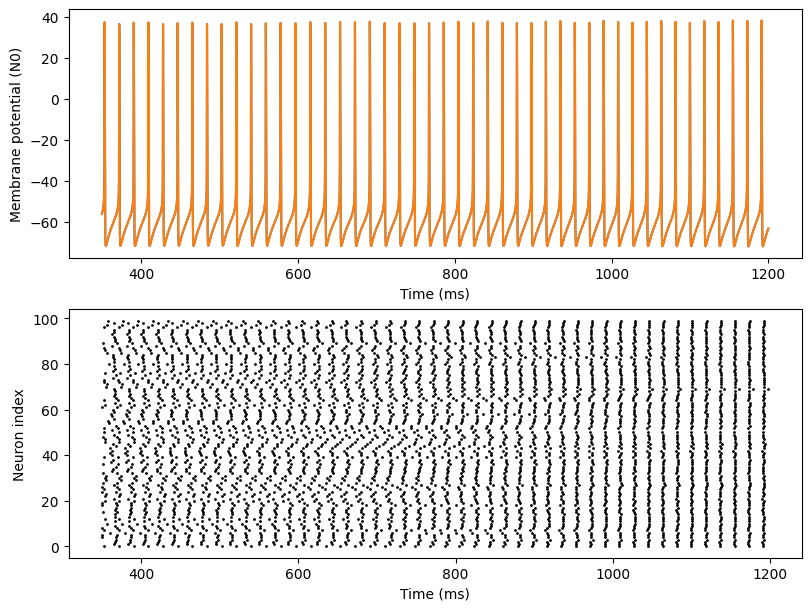

In [52]:
syn = AMPAAll2All(pre=neu, post=neu, conn= bp.connect.FixedProb(prob=0.6, include_self=False))
net = bp.Network(neu=neu, syn=syn)
runner = bp.DSRunner(net, monitors=['neu.spike', 'neu.V'], inputs=['neu.input',1.2]) #bm.random.uniform(1.2,1.32,100)]) #
runner.run(duration=1200.) #,inputs=inputs )
# NOTE: it also took some more time to reach synchronsiation .. but finally 
# may be synch index get lower as time to achieve synchronisation increases 

fig, gs = bp.visualize.get_figure(2, 1, 3, 8)

fig.add_subplot(gs[0, 0])
bp.visualize.line_plot(runner.mon.ts[7000:], runner.mon['neu.V'][7000:], ylabel='Membrane potential (N0)')
bp.visualize.line_plot(runner.mon.ts[7000:], runner.mon['neu.V'][7000:])

fig.add_subplot(gs[1, 0])
bp.visualize.raster_plot(runner.mon.ts[7000:], runner.mon['neu.spike'][7000:], show=True)
plt.show()

# probability 0.2 

In [56]:
# syn = AMPAAll2All(pre=neu, post=neu, conn=bp.connect.All2All(include_self=False)) #include_self=False)) #,stop_spike_gradient=False)
# syn = bp.dyn.GABAa.desc(pre=neu, post=neu, prob=1) #conn=bp.connect.All2All(include_self=False)) #,stop_spike_gradient=False)
syn = AMPAAll2All(pre=neu, post=neu, conn= bp.connect.FixedProb(prob=0.2, include_self=False))
syn.g_max = 0.1/100
print('='*100)
# neu = HH(10)
# V, spike

  0%|          | 0/40000 [00:00<?, ?it/s]

output = Variable(value=Traced<ShapedArray(float32[100])>with<DynamicJaxprTrace(level=2/0)>, dtype=float32)
output = Variable(value=Traced<ShapedArray(float32[100])>with<DynamicJaxprTrace(level=1/0)>, dtype=float32)


/Users/shubhangi_goyal/opt/miniconda3/lib/python3.9/site-packages/brainpy/_src/dynsys.py:294: UserWarning: 
From brainpy>=2.4.3, update() function no longer needs to receive a global shared argument.

Instead of using:

  def update(self, tdi, *args, **kwagrs):
     t = tdi['t']
     ...

Please use:

  def update(self, *args, **kwagrs):
     t = bp.share['t']
     ...

  warnings.warn(_update_deprecate_msg, UserWarning)


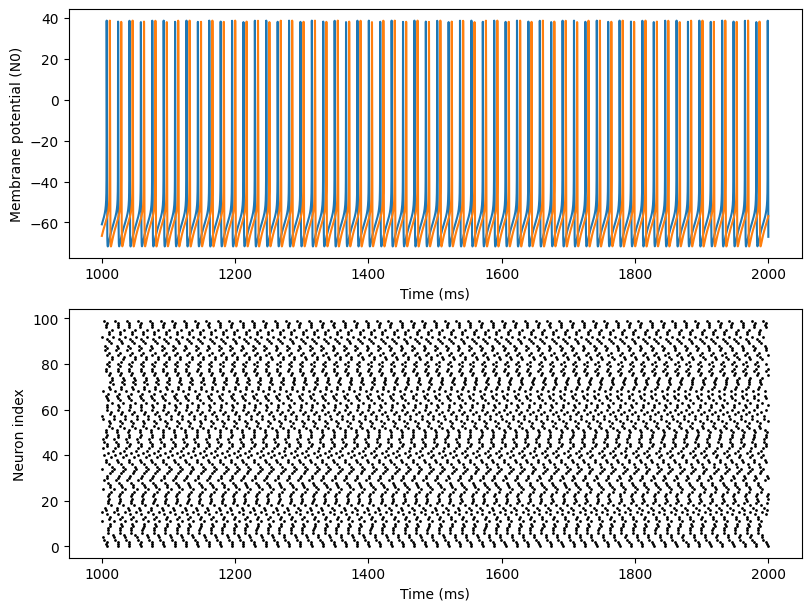

In [62]:
# so it requires a parameter search algorithm for finding weight and current 

# net = bp.Network(pre=neu, post=neu ,syn=syn)
net = bp.Network(neu=neu, syn=syn)
# runner = bp.DSRunner(net, monitors=['pre.spike', 'pre.V','post.spike', 'post.V'], inputs=[('pre.input',1.2,'fix', '+'), ('post.input',120)]) #,'fix', '=']) # bm.random.normal(1,0.02,num)])
# runner = bp.DSRunner(neu, monitors=['V','spike'], inputs=['input',1.2]) #,'fix','+']) # bm.random.normal(1,0.02,num)])
runner = bp.DSRunner(net, monitors=['neu.spike', 'neu.V'], inputs=['neu.input',1.2]) #bm.random.uniform(1.2,1.32,100)]) #
runner.run(duration=2000.) #,inputs=inputs )

#NOTE: # with low probability its difficult to achieve synchronisation 


# a = bp.DynamicalSystem() #bp.Dynamic
# #a.input
fig, gs = bp.visualize.get_figure(2, 1, 3, 8)

fig.add_subplot(gs[0, 0])
bp.visualize.line_plot(runner.mon.ts[20000:], runner.mon['neu.V'][20000:], ylabel='Membrane potential (N0)')
bp.visualize.line_plot(runner.mon.ts[20000:], runner.mon['neu.V'][20000:,10])

# bp.visualize.line_plot(runner.mon.ts, runner.mon.V[:,0], ylabel='Membrane potential (N0)')
# bp.visualize.line_plot(runner.mon.ts, runner.mon.V[:,1])

fig.add_subplot(gs[1, 0])
bp.visualize.raster_plot(runner.mon.ts[20000:], runner.mon['neu.spike'][20000:], show=True)
plt.show()

# fig, gs = bp.visualize.get_figure(2, 1, 3, 8)
#
# fig.add_subplot(gs[0, 0])
# bp.visualize.line_plot(runner.mon.ts, runner.mon['V'][:,0], ylabel='Membrane potential (N0)')
# bp.visualize.line_plot(runner.mon.ts, runner.mon['V'][:,1])
# bp.visualize.line_plot(runner.mon.ts, runner.mon['V'][:,10])
#
# # bp.visualize.line_plot(runner.mon.ts, runner.mon.V[:,0], ylabel='Membrane potential (N0)')
# # bp.visualize.line_plot(runner.mon.ts, runner.mon.V[:,1])
#
# fig.add_subplot(gs[1, 0])
# # bp.visualize.raster_plot(runner.mon.ts, runner.mon['pre.spike'], show=True)
# bp.visualize.raster_plot(runner.mon.ts, runner.mon['spike'], show=True)
# plt.show()